# Time series II
Cenying (Tracy) Yang (cenying.yang@cityu.edu.hk)

Department of Information Systems

City University of Hong Kong

In [1]:
import pandas as pd
import numpy as np
from sklearn import metrics
from scipy.stats import boxcox
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from matplotlib import pyplot as plt
%matplotlib inline

## 1. Heater demand

In [4]:
heater = pd.read_csv('heater.csv')
print(heater.head())

  year_month  demand
0    2004-01      27
1    2004-02      18
2    2004-03      14
3    2004-04      13
4    2004-05      13


Text(0.5, 1.0, 'Monthly heater demand')

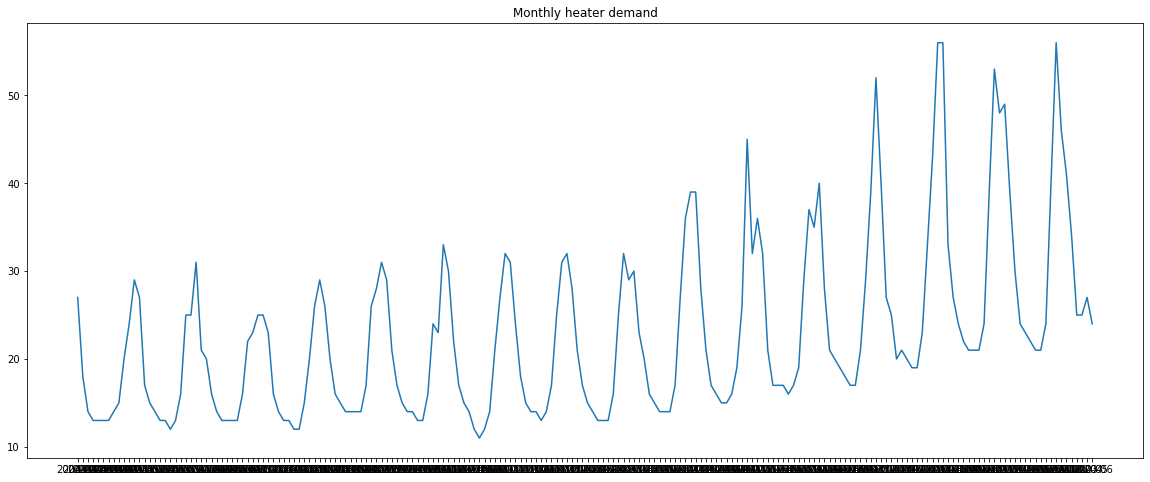

In [5]:
plt.figure(figsize = (20,8))
plt.plot(heater['year_month'], heater['demand'])
plt.title('Monthly heater demand')

### Is the time series stationary? 

#### No. The data has an increasing trend and variance, and seasonal patterns. Let's confirm with the KPSS test.

In [6]:
_, pval, __, ___ = kpss(heater['demand'], regression = 'c', nlags = 'auto')
print('p Value to the KPSS test is: ',pval)

p Value to the KPSS test is:  0.01


D:\anaconda\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


#### Because p-value is below 0.05, we consider the time series as non-stationary at a confidence level of 95%. 

#### (a) Apply Box-Cox to stabilize the variance.  

In [7]:
BCheater, lmbda = boxcox(heater['demand'])
print(BCheater[:10])
print(lmbda)

[1.33645176 1.28437989 1.24430878 1.23115726 1.23115726 1.23115726
 1.23115726 1.24430878 1.25598388 1.2992875 ]
-0.6645210955312427


Text(0.5, 1.0, 'Monthly heater demand after Box-Cox transformation')

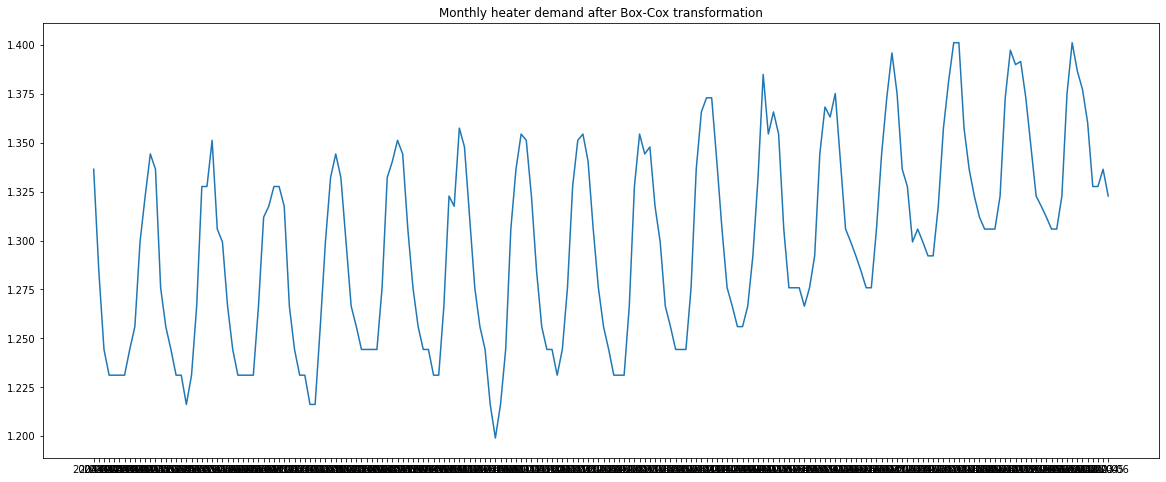

In [8]:
heater['demand_BC'] = BCheater
plt.figure(figsize = (20,8))
plt.plot(heater['year_month'], heater['demand_BC'])
plt.title('Monthly heater demand after Box-Cox transformation')

#### The issue of increasing variance is alleviated. The time series data exhibits increasing trend and seasonality. 

#### (b) Subtract monthly average to de-seasonality.

In [9]:
heater['month'] = pd.to_datetime(heater['year_month'], format = '%Y-%m').dt.month
print(heater.head())

  year_month  demand  demand_BC  month
0    2004-01      27   1.336452      1
1    2004-02      18   1.284380      2
2    2004-03      14   1.244309      3
3    2004-04      13   1.231157      4
4    2004-05      13   1.231157      5


In [10]:
heater_by_month = heater.groupby('month')['demand_BC'].mean().reset_index()
print(heater_by_month.head())

   month  demand_BC
0      1   1.354655
1      2   1.323694
2      3   1.292226
3      4   1.272576
4      5   1.265195


In [11]:
heater_by_month = heater_by_month.rename(columns = {'demand_BC':'demand_month_avg'})
print(heater_by_month.head())

   month  demand_month_avg
0      1          1.354655
1      2          1.323694
2      3          1.292226
3      4          1.272576
4      5          1.265195


In [12]:
heater = heater.merge(heater_by_month, on = 'month')
print(heater.head())

  year_month  demand  demand_BC  month  demand_month_avg
0    2004-01      27   1.336452      1          1.354655
1    2005-01      27   1.336452      1          1.354655
2    2006-01      21   1.305845      1          1.354655
3    2007-01      25   1.327616      1          1.354655
4    2008-01      26   1.332175      1          1.354655


In [13]:
# sort data by year_month in ascending order
heater = heater.sort_values('year_month')
print(heater.head())

   year_month  demand  demand_BC  month  demand_month_avg
0     2004-01      27   1.336452      1          1.354655
17    2004-02      18   1.284380      2          1.323694
34    2004-03      14   1.244309      3          1.292226
51    2004-04      13   1.231157      4          1.272576
68    2004-05      13   1.231157      5          1.265195


Text(0.5, 1.0, 'Monthly heater demand after Box-Cox transformation and de-seasonality')

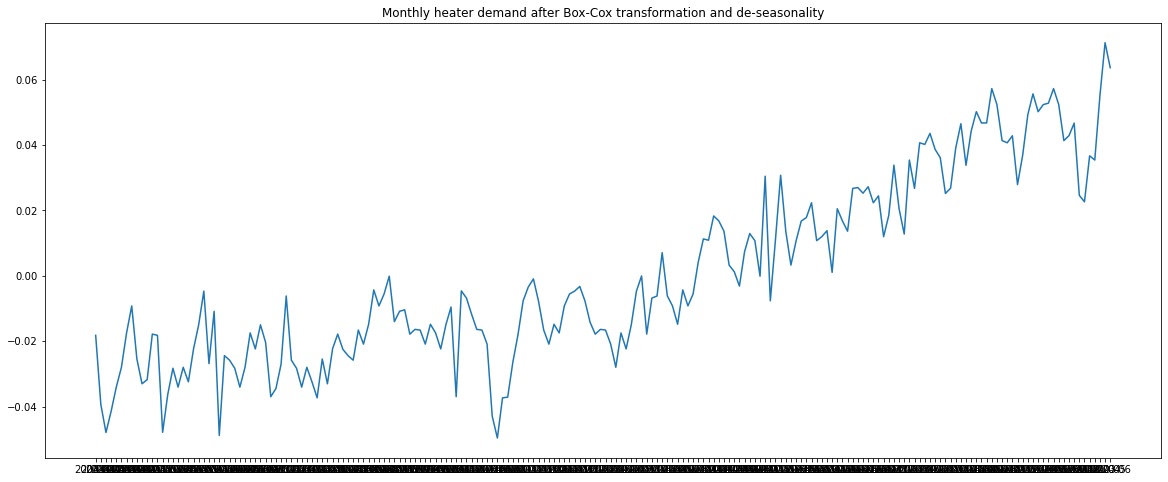

In [14]:
heater['demand_de_season'] = heater['demand_BC'] - heater['demand_month_avg']
plt.figure(figsize = (20,8))
plt.plot(heater['year_month'], heater['demand_de_season'])
plt.title('Monthly heater demand after Box-Cox transformation and de-seasonality')

#### The seasonality is removed. The time series data has an increasing trend. 

#### (c) Apply 1st order differencing to de-trend the data.

In [15]:
heater['demand_diff1'] = heater['demand_de_season'].diff()
print(heater.head())

   year_month  demand  demand_BC  month  demand_month_avg  demand_de_season  \
0     2004-01      27   1.336452      1          1.354655         -0.018203   
17    2004-02      18   1.284380      2          1.323694         -0.039314   
34    2004-03      14   1.244309      3          1.292226         -0.047917   
51    2004-04      13   1.231157      4          1.272576         -0.041419   
68    2004-05      13   1.231157      5          1.265195         -0.034038   

    demand_diff1  
0            NaN  
17     -0.021111  
34     -0.008603  
51      0.006498  
68      0.007382  


Text(0.5, 1.0, 'Monthly heater demand after Box-Cox transformation, de-seasonality, and de-trend')

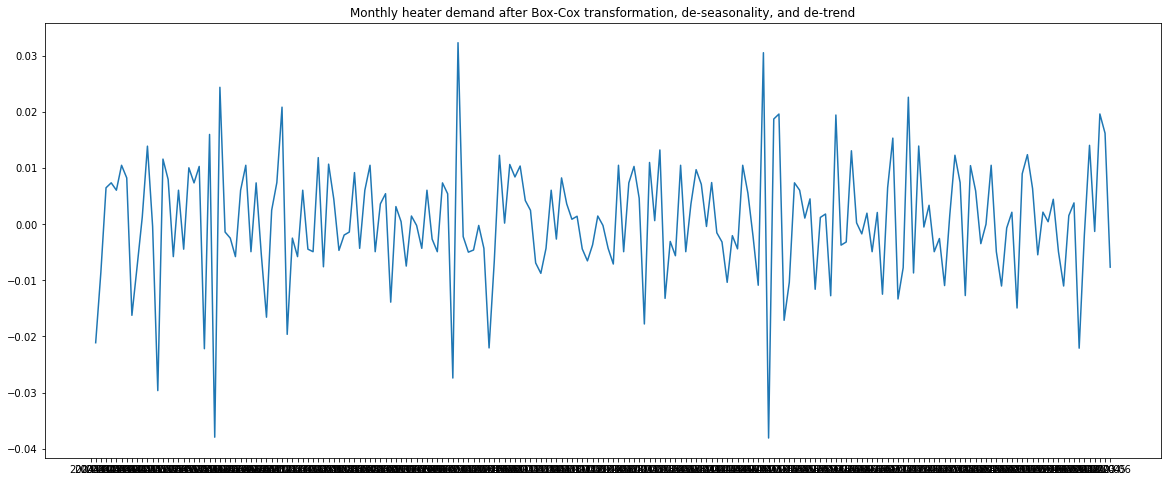

In [16]:
plt.figure(figsize = (20,8))
plt.plot(heater['year_month'], heater['demand_diff1'])
plt.title('Monthly heater demand after Box-Cox transformation, de-seasonality, and de-trend')

#### Looks much better. Let's confirm with the KPSS test.

In [17]:
_, pval, __, ___ = kpss(heater['demand_diff1'][1:], regression = 'c', nlags = 'auto') # do not include the first NaN value
print('p Value to the KPSS test is: ',pval)

p Value to the KPSS test is:  0.1


D:\anaconda\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


#### Because p-value is above 0.05, we consider the time series as stationary at a confidence level of 95%. Now, we are ready to apply an ARMA model. 

#### (a) Use PACF plot to find out the order (i.e., p) of autoregression (AR).

D:\anaconda\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


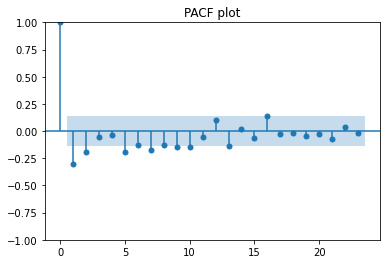

In [18]:
plot_pacf(heater['demand_diff1'][1:], title = 'PACF plot');

#### Set p = 2. Simpler model is preferred. 

#### (b) Use ACF plot to find out the order (i.e., q) of moving average (MA). 

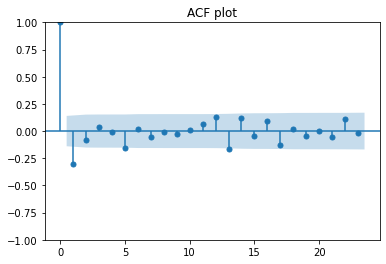

In [19]:
plot_acf(heater['demand_diff1'][1:], title = 'ACF plot');

#### Set q = 1. 

#### Now, we are ready to train an ARMA(2,1)

In [20]:
# first split our data into training and test. let's take the last 12 data points as our test data.
train = heater[:-12]
test = heater[-12:]
train.shape, test.shape

((186, 7), (12, 7))

Text(0.5, 1.0, 'Monthly heater demand')

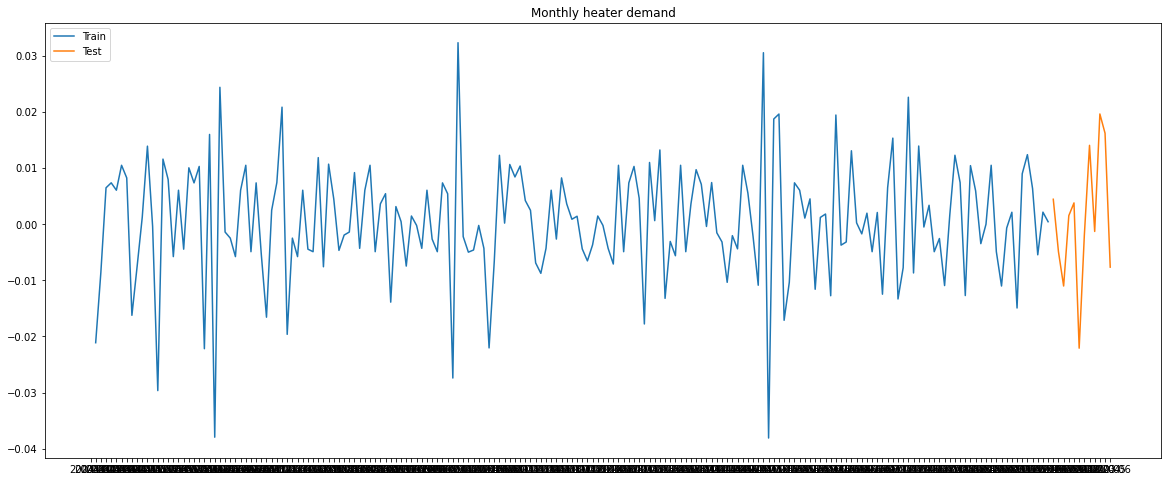

In [21]:
# plot training and testing data
plt.figure(figsize = (20,8))
plt.plot(train['year_month'], train['demand_diff1'], label = 'Train')
plt.plot(test['year_month'], test['demand_diff1'], label = 'Test')
plt.legend(loc = 'upper left')
plt.title('Monthly heater demand')

In [22]:
# 2,0,1 ARIMA Model
model = ARIMA(train['demand_diff1'], order=(2,0,1))
model_fit = model.fit()
y_predict = model_fit.forecast(12)

D:\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


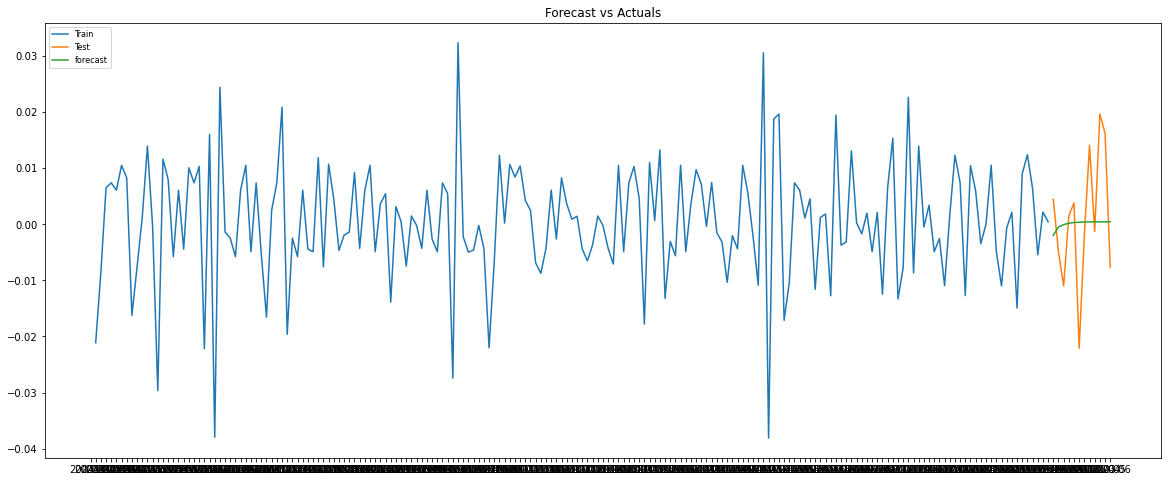

In [23]:
# Plot
plt.figure(figsize = (20,8))
plt.plot(train['year_month'], train['demand_diff1'], label = 'Train')
plt.plot(test['year_month'], test['demand_diff1'], label = 'Test')
plt.plot(test['year_month'], y_predict, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

#### Let's also try ARIMA(2,1,1) model on de-season demand. 

In [24]:
model = ARIMA(train['demand_de_season'], order=(2,1,1)) 
model_fit = model.fit()
y_predict = model_fit.forecast(12)

D:\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


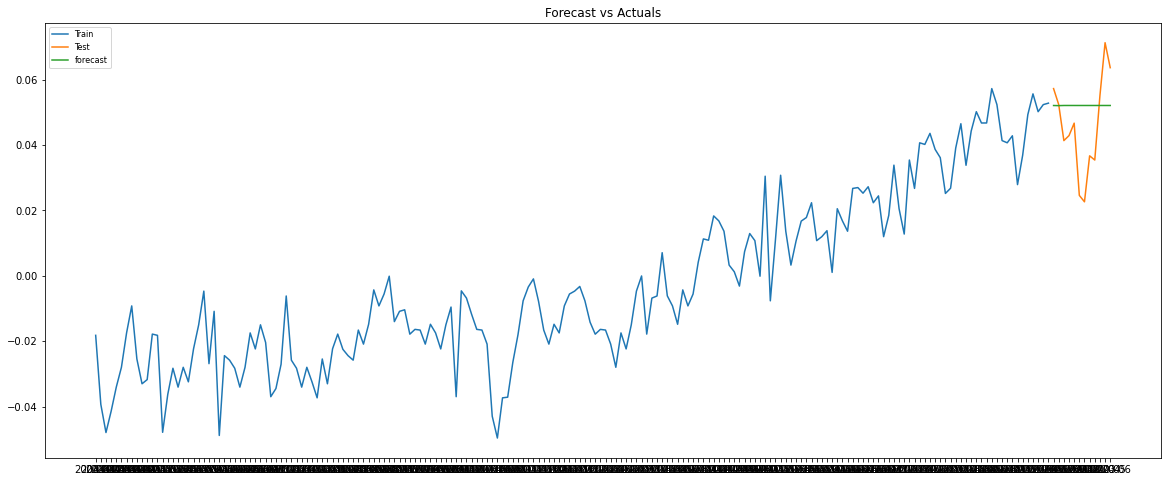

In [25]:
plt.figure(figsize = (20,8))
plt.plot(train['year_month'], train['demand_de_season'], label = 'Train')
plt.plot(test['year_month'], test['demand_de_season'], label = 'Test')
plt.plot(test['year_month'], y_predict, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

#### Let's try seasonal ARIMA on Box-Cox transformed demand. The non-seasonal part is the same as before, i.e., p = 2, d = 1, and q = 1.

#### Because the season is at month level. We take difference with lag = 12 to examine seasonal AR (P), I (D), and MA (Q). For instance, demand in January this year minus demand in January last year. 

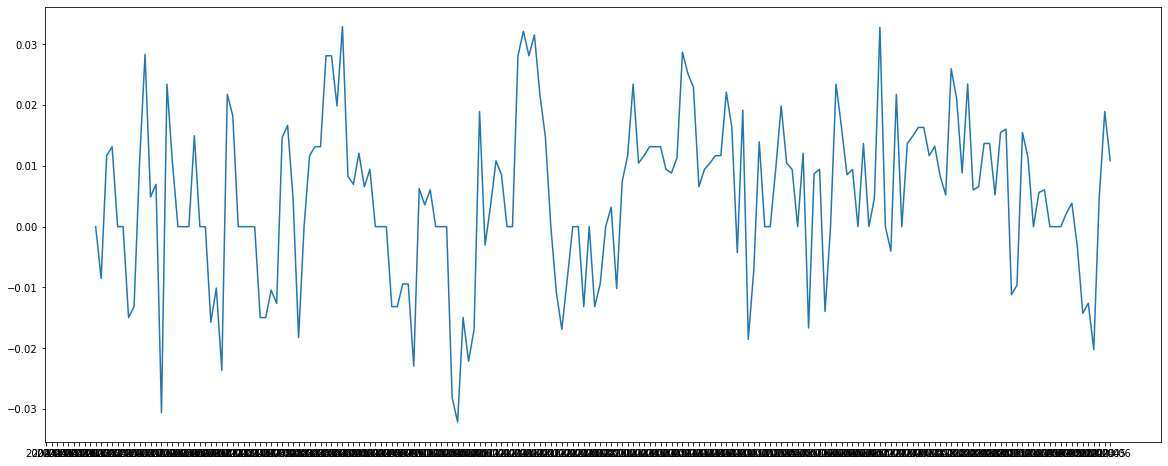

In [26]:
# plot the demand after differencing with lag = 12
plt.figure(figsize = (20,8))
plt.plot(heater['year_month'], heater['demand_BC'].diff(12))
plt.show()

#### The plot has no trend. So we do not take difference further, i.e., D = 0.

#### Use pacf to find seasonal P. P = 1. 

0           NaN
17          NaN
34          NaN
51          NaN
68          NaN
85          NaN
102         NaN
118         NaN
134         NaN
150         NaN
166         NaN
182         NaN
1      0.000000
18    -0.008535
35     0.011675
52     0.013152
69     0.000000
86     0.000000
103   -0.014951
119   -0.013152
Name: demand_BC, dtype: float64


D:\anaconda\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


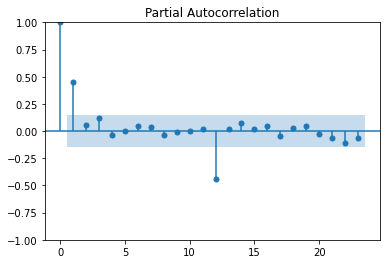

In [27]:
print(heater['demand_BC'].diff(12).head(n=20))
plot_pacf(heater['demand_BC'].diff(12)[12:]);

#### Use acf to find seasonal Q. Q = 3.

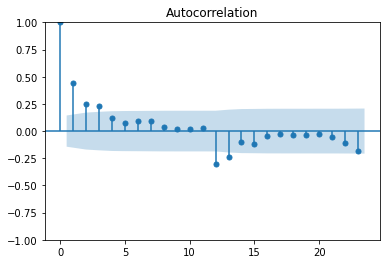

In [28]:
plot_acf(heater['demand_BC'].diff(12)[12:]);

#### Now, we are ready to apply seasonal ARIMA model. 

In [29]:
model = ARIMA(train['demand_BC'], order=(2,1,1), seasonal_order = (1,0,3,12))
model_fit = model.fit()
y_predict = model_fit.forecast(12)

D:\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-inverti

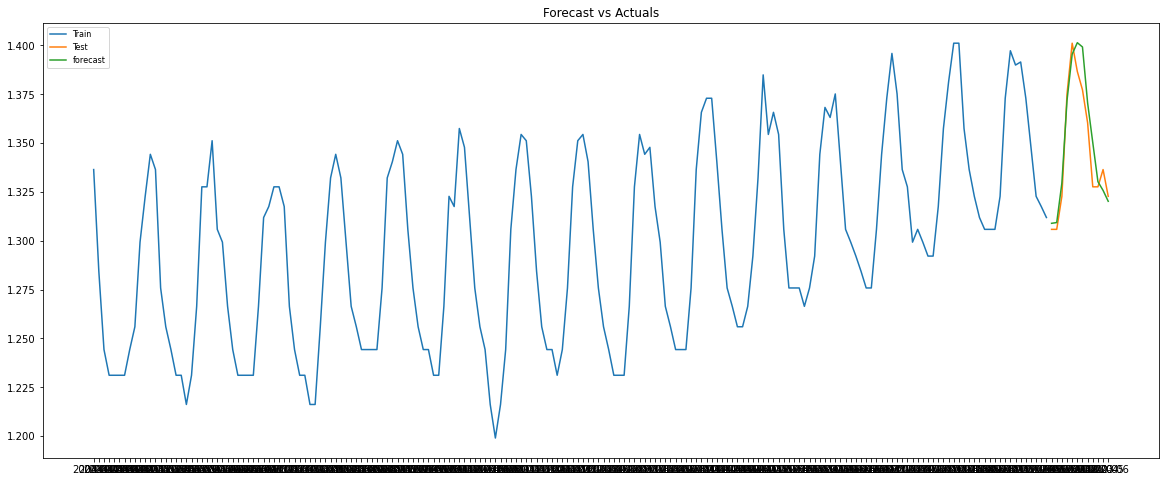

In [30]:
plt.figure(figsize = (20,8))
plt.plot(train['year_month'], train['demand_BC'], label = 'Train')
plt.plot(test['year_month'], test['demand_BC'], label = 'Test')
plt.plot(test['year_month'], y_predict, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [31]:
rmse_sarima = metrics.mean_squared_error(y_pred=y_predict,
                                       y_true=test['demand_BC'], squared = False)
print(rmse_sarima)

0.011370911264149079


In [32]:
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
hw = ETSModel(train['demand_BC'], trend='add', seasonal = 'add', seasonal_periods = 12)
hw_fit = hw.fit()
y_predict = hw_fit.forecast(12)

D:\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


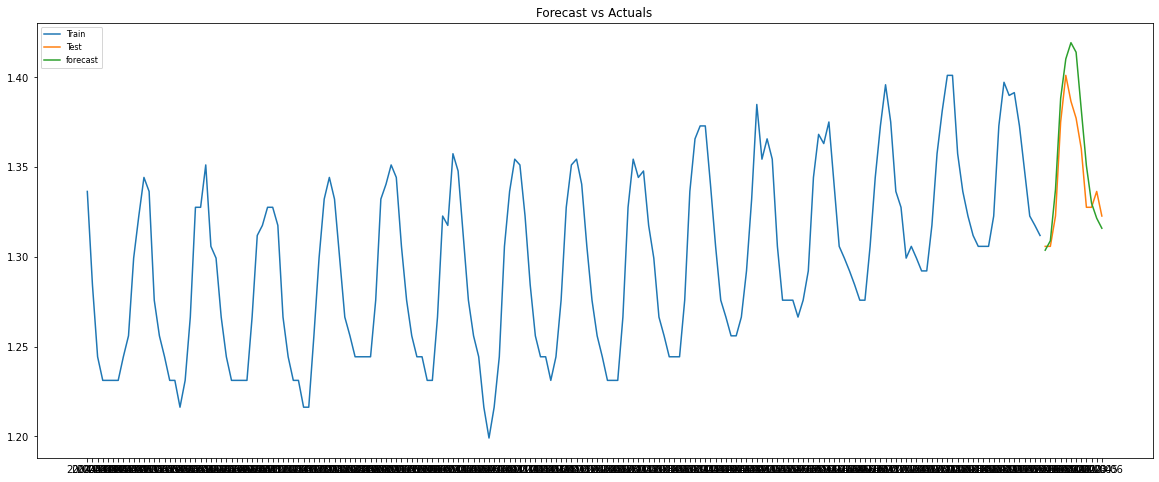

In [33]:
plt.figure(figsize = (20,8))
plt.plot(train['year_month'], train['demand_BC'], label = 'Train')
plt.plot(test['year_month'], test['demand_BC'], label = 'Test')
plt.plot(test['year_month'], y_predict, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [32]:
rmse_hw = metrics.mean_squared_error(y_pred=y_predict,
                                       y_true=test['demand_BC'], squared = False)
print(rmse_hw)

0.018704793298756506
